In [94]:
import numpy as np
import scipy
import cv2
import skimage
import skimage.io
import matplotlib.pyplot as plt

def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)

In [95]:
# padding the source and mask to be same size as target

def padding(src, mask, dst, center):
    if center is None:
        return src, mask
    dst_h = dst.shape[0]
    dst_w = dst.shape[1]
    cx = center[0]
    cy = center[1]
    src_h = src.shape[0]
    src_w = src.shape[1]

    # TODO: handle edge cases
    top_pad = cy - int(src_h/2)
    bottom_pad = dst_h - src_h - top_pad
    left_pad = cx - int(src_w/2)  
    right_pad = dst_w - src_w - left_pad
    
    src = cv2.copyMakeBorder(src, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT)
    mask = cv2.copyMakeBorder(mask, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT)
    return src, mask



In [96]:
from scipy.sparse import linalg
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

OUTSIDE = 0
INSIDE = 2
BOUNDARY = 1

def get_neighbor(pt, shape = None):
    row, col = pt
    
    if shape is None:
        return [(row,col-1),(row,col+1),(row-1,col),(row+1,col)]
    
    max_row = shape[0]-1
    max_col = shape[1]-1
    
    if row == 0:
        if col == 0:
            return [(row,col+1),(row+1,col)]
        elif col == max_col:
            return [(row,col-1),(row+1,col)]
        else:
            return [(row,col-1),(row,col+1),(row+1,col)]
    elif row == max_row:
        if col == 0:
            return [(row,col+1),(row-1,col)]
        elif col == max_col:
            return [(row,col-1),(row-1,col)]
        else:
            return [(row,col-1),(row,col+1),(row-1,col)]
    else:
        return [(row,col-1),(row,col+1),(row-1,col),(row+1,col)]

def pixel_location(pt, mask):
    # pt = (row, col)
    if mask[pt] == 0:
        return OUTSIDE
    elif mask[pt] == 1:
        for nb in get_neighbor(pt, None): # assume it's not on edge
            if mask[nb] == 0:
                return BOUNDARY  
        return INSIDE

def get_mask_region(mask):
    # return INSIDE points and a look up table for finding index from point position
    inside_pts = np.where(mask)
    ret = list(zip(inside_pts[0],inside_pts[1]))
    ret = np.array(ret)
    min_H,min_W = np.min(ret, axis = 0)
    max_H,max_W = np.max(ret, axis = 0)
    return min_H,min_W,max_H,max_W

In [97]:
def choose_grad(grad1, grad2):
    if abs(grad1) > abs(grad2):
        return grad1
    else:
        return grad2
    
def mix_grad(grad1, grad2, ratio):
    return grad1*ratio + grad2*(1-ratio)

def get_A_b(src, mask, dst, mixing_grad = True, ratio = None):
    # get the region where possion editing will perform 
    min_H,min_W,max_H,max_W = get_mask_region(mask)
    
    mask = mask[min_H:max_H+1,min_W:max_W+1]
    src = src[min_H:max_H+1,min_W:max_W+1]
    dst_sub = dst[min_H:max_H+1,min_W:max_W+1]
    
    Hs,Ws = mask.shape
    num_pxls = Hs * Ws
    
    # source and target image
    src = src.flatten(order = 'C')
    dst_sub = dst_sub.flatten(order = 'C')
    mask = mask.flatten(order = 'C')
    guidance_field = np.empty_like(mask)
    A = lil_matrix((num_pxls, num_pxls), dtype='float64')
    
    for i in range(num_pxls):
        if mask[i] > 0.99:
            A[i,i] = 4
            # divided by four neighbor direction
            
            # up
            if(i > Ws):
                A[i,i-Ws] = -1
                nb_up_s = src[i] - src[i-Ws]
                nb_up_t = dst_sub[i] - dst_sub[i-Ws]
            else:
                # at top, top neighbor will be equal to T(top)
                nb_up_s = src[i]
                nb_up_t = dst_sub[i]
            
            # left
            if(i % Ws != 0):
                A[i, i-1] = -1
                nb_left_s = src[i] - src[i-1]
                nb_left_t = dst_sub[i] - dst_sub[i-1]
            else:
                nb_left_s = src[i]
                nb_left_t = dst_sub[i]
            
            # down
            if(i + Ws < num_pxls):
                A[i, i+Ws] = -1
                nb_down_s = src[i] - src[i+Ws]
                nb_down_t = dst_sub[i] - dst_sub[i+Ws]
            else:
                nb_down_s = src[i]
                nb_down_t = dst_sub[i]

            # right
            if(i % Ws != Ws-1):
                A[i, i+1] = -1
                nb_right_s = src[i] - src[i+1]
                nb_right_t = dst_sub[i] - dst_sub[i+1]
            else:
                nb_right_s = src[i]
                nb_right_t = dst_sub[i]            
            
            if mixing_grad is False: # only using src gradient
                nb_up_t = 0
                nb_left_t = 0
                nb_down_t = 0
                nb_right_t = 0
            
            if ratio is None:
                guidance_field[i] = choose_grad(nb_up_t, nb_up_s) + choose_grad(nb_left_t, nb_left_s) + choose_grad(nb_down_t, nb_down_s) + choose_grad(nb_right_t, nb_right_s)
            else:
                guidance_field[i] = mix_grad(nb_up_t, nb_up_s, ratio) + mix_grad(nb_left_t, nb_left_s, ratio)\
                    + mix_grad(nb_down_t, nb_down_s, ratio) + mix_grad(nb_right_t, nb_right_s, ratio)
        
        else:
            A[i,i] = 1 # just copy dst
            guidance_field[i] = dst_sub[i]
    return A, guidance_field

def solve_x(A, b, mask_shape):
    x = linalg.spsolve(A.tocsc(),b)
    return np.reshape(x,(mask_shape[0],mask_shape[1]))

def merge_final(source, target, min_H,min_W,max_H,max_W):
    target[min_H:max_H+1,min_W:max_W+1,:] = source
    return target

def possion_blend(src, mask, dst, mixing_grad = True ,ratio = None):
    
    min_H,min_W,max_H,max_W = get_mask_region(mask)
    mask_shape = (max_H - min_H + 1, max_W - min_W + 1)
    
    A_b_list = []
    for ch in range(3):
        src_ch = src[:,:,ch]
        mask_ch = mask
        dst_ch = dst[:,:,ch]
        A,b = get_A_b(src_ch, mask_ch, dst_ch, mixing_grad, ratio)
        A_b_list.append([A,b])
    
    # solve
    output = np.zeros((mask_shape[0],mask_shape[1],3))
    for i in range(3):
        output[:,:,i] = solve_x(A_b_list[i][0],A_b_list[i][1],mask_shape)
    
    output = merge_final(output, dst, min_H,min_W,max_H,max_W)
    return output

In [98]:
def load_imgs(source_path, target_path, mask_path):
    
    source_img = imread(source_path)
    target_img = imread(target_path)
    mask_img = imread_bw(mask_path)
    return source_img,mask_img,target_img

def preprocess(source_img,mask_img,target_img, center = None):
    source_img = cv2.normalize(source_img.astype('float'), None, 0.0, 1.0, norm_type=cv2.NORM_MINMAX)
    mask_img = cv2.normalize(mask_img.astype('float'), None, 0.0, 1.0, norm_type=cv2.NORM_MINMAX)
    target_img = cv2.normalize(target_img.astype('float'), None, 0.0, 1.0, norm_type=cv2.NORM_MINMAX)

    src, mask = padding(source_img, mask_img, target_img, center)
    dst = target_img
    
    return src, mask, dst

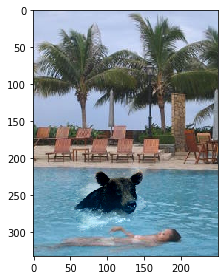

In [99]:
source_path = './data/source_01.jpg'
target_path = './data/target_01.jpg'
mask_path = './data/mask_01.jpg'
center = (120,250)
src, mask, dst = load_imgs(source_path, target_path, mask_path)
src, mask, dst = preprocess(src, mask, dst, center = center)
# imshow(padding(source_img, mask_img, target_img, center)[0])
# plt.show()
# imshow(padding(source_img, mask_img, target_img, center)[1])
# plt.show()

output = possion_blend(src, mask, dst, mixing_grad = True, ratio = 0.1)
output = np.clip(output,0.0,1.0)

output = output*255
output = output.astype(np.uint8)

imshow(output)

naive copy


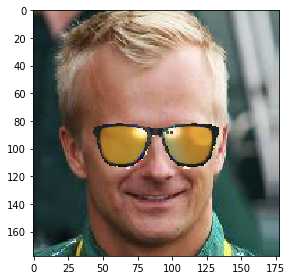

possion blend with mixing gradient


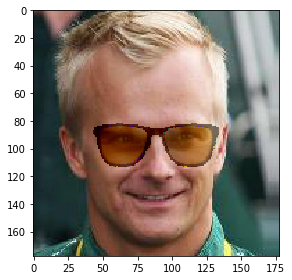

In [118]:
import os

def load_face_sunglasses(paired_img, mask_img):
    W = paired_img.shape[1]
    H = paired_img.shape[0]
    
    target_img = paired_img[:,H:2*H,:]
    src_img = paired_img[:,4*H:,:]
    mask_img = mask_img[:,H:]
    assert target_img.shape[:2] == mask_img.shape == src_img.shape[:2]
    return preprocess(src_img, mask_img, target_img, center = None)

def naive_copy(src, mask, dst):
    region = np.where(mask)
    ret = dst.copy()
    for i,j in zip(region[0], region[1]):
        ret[i,j] = src[i,j]
    return ret

# try face_sunglasses dataset:
paired_path = './face_sunglasses/paired/images/'
mask_path = './face_sunglasses/unpaired/masks/'
idx = 10

# load imgs
paired_img = imread(os.path.join(paired_path,f'{idx}.png'))
mask_img = imread_bw(os.path.join(mask_path,f'{idx}.png'))
src, mask, dst = load_face_sunglasses(paired_img, mask_img)

# naive copy
output_naive = naive_copy(src,mask,dst)
print('naive copy')
imshow(output_naive)
plt.show()

print('possion blend with mixing gradient')
output = possion_blend(src, mask, dst, mixing_grad = True, ratio = 0.5)
output = np.clip(output,0.0,1.0)

output = output*255
output = output.astype(np.uint8)

imshow(output)
plt.show()